In [2]:
import sys
sys.path.append('..')

<font size=4> __FORECASTING__ </font>

<div>
<img src="https://otexts.com/fpp3/fpp_files/figure-html/workflow-1.png">
</div>

Reference:
https://otexts.com/fpp3/a-tidy-forecasting-workflow.html

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from study_lib.read_data import SML2010Data

In [4]:
df = SML2010Data.get_data()

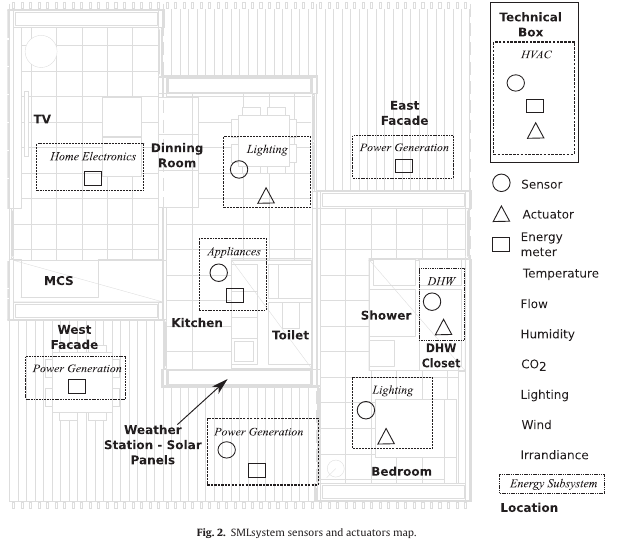

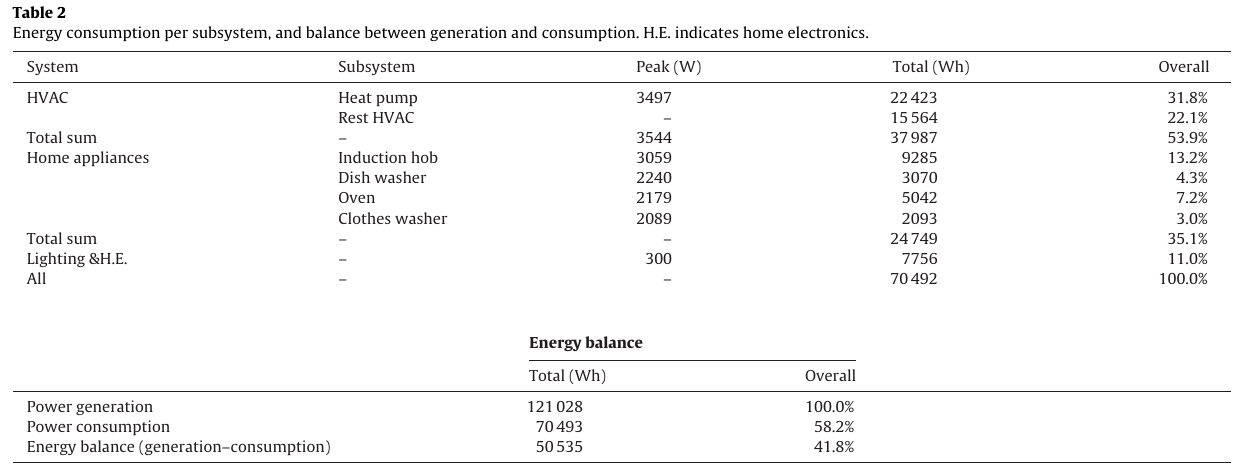

References:
- F. Zamora-Martínez, P. Romeu, P. Botella-Rocamora, J. Pardo, On-line learning of indoor temperature forecasting models towards energy efficiency, Energy and Buildings, Volume 83, November 2014, Pages 162-172, ISSN 0378-7788

- F. Zamora-Martínez, P. Romeu, P. Botella-Rocamora, J. Pardo, Towards energy efficiency: forecasting indoor temperature via multivariate analysis, Energies 6 (2013) 4639–4659.

Objective: Forecast indoor temperature (room and dining room) for all time steps in a 3 hour horizon.

# Exploratory Data Analysis

In [5]:
df.head()

,Date,Time,Temperature_dining_room,Temperature_room,Weather_temperature,CO2_dining_room,CO2_room,Humidity_dining_room,Humidity_room,Lighting_dining_room,...,Sun_light_west,Sun_light_east,Sun_light_south,Sun_irradiance,Enthalpic_motor_1,Enthalpic_motor_2,Enthalpic_motor_turbo,Outdoor_temperature,Outdoor_relative_humidity,Day_of_week
0,13/03/2012,11:45,18.1875,17.8275,0.0,216.560,221.920,39.9125,42.4150,81.6650,...,9690.24,12604.20,95436.8,758.880,0,0,0,18.1150,48.3750,2.0
1,13/03/2012,12:00,18.4633,18.1207,6.8,219.947,220.363,39.9267,42.2453,81.7413,...,11022.00,10787.20,95436.8,762.069,0,0,0,18.4147,47.8080,2.0
2,13/03/2012,12:15,18.7673,18.4367,17.0,219.403,218.933,39.7720,42.2267,81.4240,...,13960.50,9669.63,95398.6,766.251,0,0,0,18.8533,47.4320,2.0
3,13/03/2012,12:30,19.0727,18.7513,18.0,218.613,217.045,39.7760,42.0987,81.5013,...,18511.20,9648.13,95360.3,766.037,0,0,0,19.2907,47.0240,2.0
4,13/03/2012,12:45,19.3721,19.0414,20.0,217.714,216.080,39.7757,42.0686,81.4657,...,26349.00,9208.32,95354.9,762.743,0,0,0,19.7400,45.4743,2.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4137 entries, 0 to 4136
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       4137 non-null   object 
 1   Time                       4137 non-null   object 
 2   Temperature_dining_room    4137 non-null   float64
 3   Temperature_room           4137 non-null   float64
 4   Weather_temperature        4137 non-null   float64
 5   CO2_dining_room            4137 non-null   float64
 6   CO2_room                   4137 non-null   float64
 7   Humidity_dining_room       4137 non-null   float64
 8   Humidity_room              4137 non-null   float64
 9   Lighting_dining_room       4137 non-null   float64
 10  Lighting_room              4137 non-null   float64
 11  Rain                       4137 non-null   float64
 12  Sun_dusk                   4137 non-null   float64
 13  Wind                       4137 non-null   float

## Shaping as time series

In [7]:
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

In [8]:
df.Timestamp

0      2012-03-13 11:45:00
1      2012-03-13 12:00:00
2      2012-03-13 12:15:00
3      2012-03-13 12:30:00
4      2012-03-13 12:45:00
               ...        
4132   2012-05-02 06:30:00
4133   2012-05-02 06:45:00
4134   2012-05-02 07:00:00
4135   2012-05-02 07:15:00
4136   2012-05-02 07:30:00
Name: Timestamp, Length: 4137, dtype: datetime64[ns]

In [9]:
new_df = df.set_index('Timestamp').sort_index()

In [10]:
new_df.index

DatetimeIndex(['2012-03-13 11:45:00', '2012-03-13 12:00:00',
               '2012-03-13 12:15:00', '2012-03-13 12:30:00',
               '2012-03-13 12:45:00', '2012-03-13 13:00:00',
               '2012-03-13 13:15:00', '2012-03-13 13:30:00',
               '2012-03-13 13:45:00', '2012-03-13 14:00:00',
               ...
               '2012-05-02 05:15:00', '2012-05-02 05:30:00',
               '2012-05-02 05:45:00', '2012-05-02 06:00:00',
               '2012-05-02 06:15:00', '2012-05-02 06:30:00',
               '2012-05-02 06:45:00', '2012-05-02 07:00:00',
               '2012-05-02 07:15:00', '2012-05-02 07:30:00'],
              dtype='datetime64[ns]', name='Timestamp', length=4137, freq=None)

In [11]:
# Why did he not infer the frequency?
(new_df.index[1:] - new_df.index[:-1]).value_counts()

0 days 00:15:00    4133
0 days 00:30:00       2
6 days 17:30:00       1
Name: Timestamp, dtype: int64

In [12]:
np.argwhere((new_df.index[1:] - new_df.index[:-1]) > pd.Timedelta(15, unit="m"))

array([[2763],
       [4119],
       [4125]])

In [13]:
new_df.iloc[2761:2765]

,Date,Time,Temperature_dining_room,Temperature_room,Weather_temperature,CO2_dining_room,CO2_room,Humidity_dining_room,Humidity_room,Lighting_dining_room,...,Sun_light_west,Sun_light_east,Sun_light_south,Sun_irradiance,Enthalpic_motor_1,Enthalpic_motor_2,Enthalpic_motor_turbo,Outdoor_temperature,Outdoor_relative_humidity,Day_of_week
Timestamp,,,,,,,,,,,,,,,,,,,,,
2012-04-11 06:00:00,11/04/2012,06:00,20.9347,20.5827,12.0000,190.432,193.653,41.3333,41.7573,19.5387,...,3454.98,16203.8,3347.46,26.8300,0,0,0,16.2607,50.0587,3.0
2012-04-11 06:15:00,11/04/2012,06:15,20.8560,20.5200,12.0000,191.531,193.387,41.3093,41.8107,20.9853,...,6795.26,38303.1,7110.66,66.9493,0,0,0,16.2367,49.8400,3.0
2012-04-11 06:30:00,11/04/2012,06:30,20.7627,20.4400,12.1333,191.563,193.664,41.2800,41.8373,20.5620,...,8952.83,51347.5,10270.70,112.2670,0,0,0,16.2860,50.2987,3.0
2012-04-18 00:00:00,18/04/2012,00:00,20.2000,19.8000,13.0000,207.840,206.560,31.5800,30.1600,11.7200,...,0.00,0.0,0.00,-3.1200,0,0,0,16.0700,39.0800,3.0


In [14]:
new_df.iloc[4117:4121]

,Date,Time,Temperature_dining_room,Temperature_room,Weather_temperature,CO2_dining_room,CO2_room,Humidity_dining_room,Humidity_room,Lighting_dining_room,...,Sun_light_west,Sun_light_east,Sun_light_south,Sun_irradiance,Enthalpic_motor_1,Enthalpic_motor_2,Enthalpic_motor_turbo,Outdoor_temperature,Outdoor_relative_humidity,Day_of_week
Timestamp,,,,,,,,,,,,,,,,,,,,,
2012-05-02 02:15:00,02/05/2012,02:15,20.3867,19.9720,11.0,195.413,199.765,43.0747,45.2480,11.4260,...,0.0,0.0,0.0,-3.042,0,0,0,15.1020,62.8960,3.0
2012-05-02 02:30:00,02/05/2012,02:30,20.2887,19.8787,11.0,197.173,200.533,42.7147,44.9333,11.6053,...,0.0,0.0,0.0,-2.808,0,0,0,15.0433,62.7200,3.0
2012-05-02 02:45:00,02/05/2012,02:45,20.1646,19.7692,11.0,197.723,201.748,42.6277,44.9138,11.7008,...,0.0,0.0,0.0,-2.850,0,0,0,14.8946,62.9969,3.0
2012-05-02 03:15:00,02/05/2012,03:15,20.0600,19.6220,11.0,197.824,201.264,42.6760,44.9480,11.6950,...,0.0,0.0,0.0,-2.769,0,0,0,14.7580,63.2360,3.0


In [15]:
new_df.iloc[4123:4127]

,Date,Time,Temperature_dining_room,Temperature_room,Weather_temperature,CO2_dining_room,CO2_room,Humidity_dining_room,Humidity_room,Lighting_dining_room,...,Sun_light_west,Sun_light_east,Sun_light_south,Sun_irradiance,Enthalpic_motor_1,Enthalpic_motor_2,Enthalpic_motor_turbo,Outdoor_temperature,Outdoor_relative_humidity,Day_of_week
Timestamp,,,,,,,,,,,,,,,,,,,,,
2012-05-02 04:00:00,02/05/2012,04:00,19.6653,19.1927,11.0,199.147,202.155,42.8400,45.0693,11.7680,...,0.0,0.0,0.0,-2.49600,0,0,0,14.3233,62.6000,3.0
2012-05-02 04:15:00,02/05/2012,04:15,19.5613,19.0813,11.0,199.285,202.027,42.7360,45.0213,11.7033,...,0.0,0.0,0.0,-2.73000,0,0,0,14.2127,62.7413,3.0
2012-05-02 04:30:00,02/05/2012,04:30,19.4413,18.9647,11.0,199.360,201.419,42.6907,44.9840,11.5240,...,0.0,0.0,0.0,-2.65200,0,0,0,14.1000,62.7787,3.0
2012-05-02 05:00:00,02/05/2012,05:00,19.2877,18.7877,11.0,200.228,202.788,42.6831,44.9415,11.6442,...,0.0,0.0,0.0,-2.05462,0,0,0,13.8977,63.5369,3.0


In [16]:
new_df.tail()

,Date,Time,Temperature_dining_room,Temperature_room,Weather_temperature,CO2_dining_room,CO2_room,Humidity_dining_room,Humidity_room,Lighting_dining_room,...,Sun_light_west,Sun_light_east,Sun_light_south,Sun_irradiance,Enthalpic_motor_1,Enthalpic_motor_2,Enthalpic_motor_turbo,Outdoor_temperature,Outdoor_relative_humidity,Day_of_week
Timestamp,,,,,,,,,,,,,,,,,,,,,
2012-05-02 06:30:00,02/05/2012,06:30,18.8000,18.2667,11.0000,199.424,201.963,43.0160,44.9813,21.8500,...,6636.54,35671.4,7454.38,124.496,0,0,0,14.4833,58.9920,3.0
2012-05-02 06:45:00,02/05/2012,06:45,18.7713,18.2153,11.7333,199.200,202.091,43.1920,44.9413,21.1653,...,11818.30,71188.5,12526.90,256.597,0,0,0,14.7540,58.6213,3.0
2012-05-02 07:00:00,02/05/2012,07:00,18.7860,18.2000,12.0000,199.435,201.739,43.3947,44.9333,21.2640,...,10836.30,69498.2,12597.90,281.568,0,0,0,15.2020,57.6960,3.0
2012-05-02 07:15:00,02/05/2012,07:15,18.8133,18.2153,12.5333,200.107,200.597,43.3440,44.7013,28.1647,...,11722.10,79102.0,15796.90,354.645,0,0,0,15.7260,56.8613,3.0
2012-05-02 07:30:00,02/05/2012,07:30,18.8600,18.2667,13.0000,200.149,199.541,43.6667,44.5653,31.1107,...,11819.70,81240.1,19035.50,404.992,0,0,0,16.2693,55.8907,3.0


- Let us remove the points from 2012-05-02 forward

In [17]:
# Removing the tail
data = new_df.loc[new_df.index < '2012-05-02'] 

In [18]:
data.tail()

,Date,Time,Temperature_dining_room,Temperature_room,Weather_temperature,CO2_dining_room,CO2_room,Humidity_dining_room,Humidity_room,Lighting_dining_room,...,Sun_light_west,Sun_light_east,Sun_light_south,Sun_irradiance,Enthalpic_motor_1,Enthalpic_motor_2,Enthalpic_motor_turbo,Outdoor_temperature,Outdoor_relative_humidity,Day_of_week
Timestamp,,,,,,,,,,,,,,,,,,,,,
2012-05-01 22:45:00,01/05/2012,22:45,21.8400,21.3387,15.0000,197.163,199.381,43.4053,44.4773,11.5240,...,0.0,0.0,0.0,-2.886,0,0,0,16.6400,63.1947,2.0
2012-05-01 23:00:00,01/05/2012,23:00,21.7173,21.2293,15.0000,197.184,198.293,43.4907,44.6800,11.6053,...,0.0,0.0,0.0,-2.886,0,0,0,16.5700,62.7547,2.0
2012-05-01 23:15:00,01/05/2012,23:15,21.6053,21.1307,15.0000,195.989,197.771,43.2293,44.6800,11.6867,...,0.0,0.0,0.0,-2.886,0,0,0,16.5267,61.7573,2.0
2012-05-01 23:30:00,01/05/2012,23:30,21.4933,21.0213,15.0000,196.181,197.077,42.9227,44.6507,11.6220,...,0.0,0.0,0.0,-2.808,0,0,0,16.4313,61.7680,2.0
2012-05-01 23:45:00,01/05/2012,23:45,21.3827,20.9253,14.3333,195.616,196.736,42.9600,44.7227,11.6053,...,0.0,0.0,0.0,-2.886,0,0,0,16.3627,61.4080,2.0


In [19]:
data.shape

(4108, 24)

In [21]:
data.loc[:'2012-04-12 00:00:00'].shape

(2764, 24)

In [22]:
data.loc['2012-04-12 00:00:00':].shape

(1344, 24)

- Between 2012-04-11 06:30:00 and 2012-04-18 00:00:00, there is a whole week missing. What do we do?

So, first of all, many methods still work even with missing data (RNNs, Hidden Markov Models and ARIMA/SARIMAX works fine). Others do not (ETS).

Since most of the methods I want to try here are "okay" with missing data, I will just ignore them.

Also, that week is really close to the test data if we split 70\% train and 30\% test. So, we will take 2012-04-18 forward as test data.

In [24]:
data['Day_of_week'] = np.floor(data['Day_of_week'])

/home/alexandre/anaconda2/envs/data_science/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Checking the data

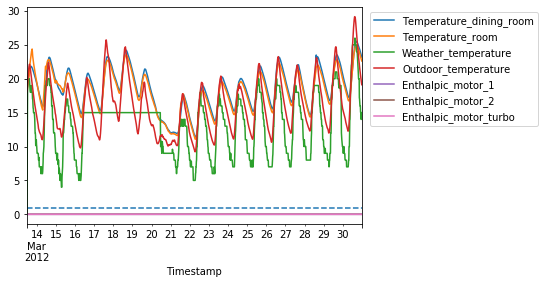

In [25]:
plot_cols = ['Temperature_dining_room', 'Temperature_room', 
             'Weather_temperature', 'Outdoor_temperature',
             'Enthalpic_motor_1', 'Enthalpic_motor_2',
             'Enthalpic_motor_turbo']

data.loc[:'2012-3-30 23:59:59'].plot.line(y=plot_cols)
plt.legend(bbox_to_anchor=(1.01,1), )
plt.axhline(1,linestyle='dashed')
plt.show()

In [26]:
data['Enthalpic_motor_1'].value_counts()

0    4108
Name: Enthalpic_motor_1, dtype: int64

In [27]:
data['Enthalpic_motor_2'].value_counts()

0    4108
Name: Enthalpic_motor_2, dtype: int64

In [28]:
data['Enthalpic_motor_turbo'].value_counts()

0    4108
Name: Enthalpic_motor_turbo, dtype: int64

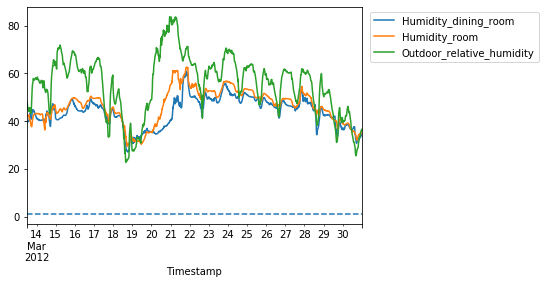

In [29]:
plot_cols = ['Humidity_dining_room', 'Humidity_room', 'Outdoor_relative_humidity']

data.loc[:'2012-3-30 23:59:59'].plot.line(y=plot_cols)
plt.legend(bbox_to_anchor=(1.01,1), )
plt.axhline(1,linestyle='dashed')
plt.show()

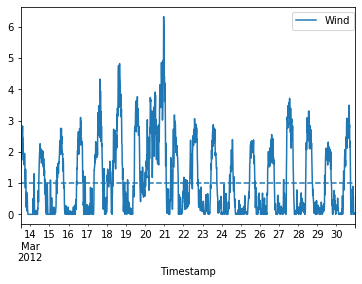

In [30]:
plot_cols = ['Wind']

data.loc[:'2012-3-30 23:59:59'].plot.line(y=plot_cols)
plt.legend(bbox_to_anchor=(1.01,1), )
plt.axhline(1,linestyle='dashed')
plt.show()

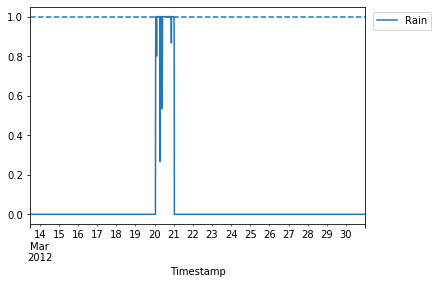

In [31]:
plot_cols = ['Rain']

data.loc[:'2012-3-30 23:59:59'].plot.line(y=plot_cols)
plt.legend(bbox_to_anchor=(1.01,1), )
plt.axhline(1,linestyle='dashed')
plt.show()

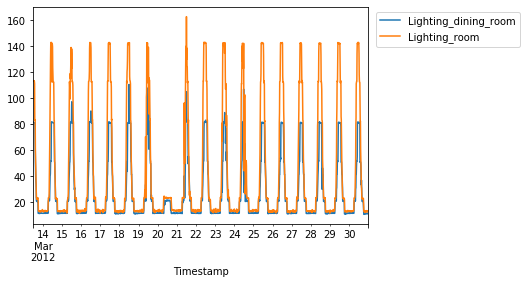

In [32]:
plot_cols = ['Lighting_dining_room', 'Lighting_room']

data.loc[:'2012-3-30 23:59:59'].plot.line(y=plot_cols)
plt.legend(bbox_to_anchor=(1.01,1), )
# plt.axhline(1,linestyle='dashed')
plt.show()

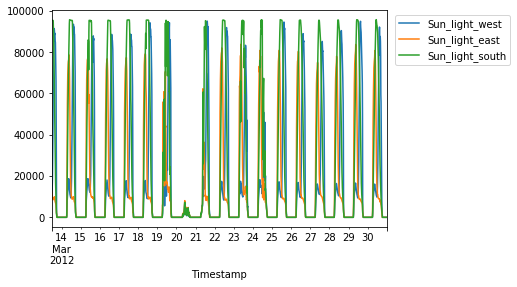

In [33]:
plot_cols = ['Sun_light_west', 'Sun_light_east', 'Sun_light_south']

data.loc[:'2012-3-30 23:59:59'].plot.line(y=plot_cols)
plt.legend(bbox_to_anchor=(1.01,1), )
# plt.axhline(1,linestyle='dashed')
plt.show()

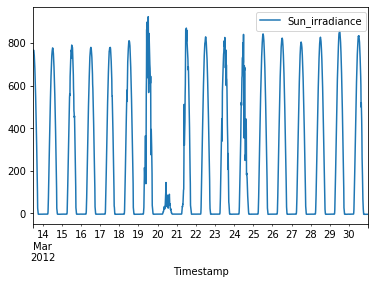

In [34]:
plot_cols = ['Sun_irradiance']

data.loc[:'2012-3-30 23:59:59'].plot.line(y=plot_cols)
plt.legend(bbox_to_anchor=(1.01,1), )
# plt.axhline(1,linestyle='dashed')
plt.show()

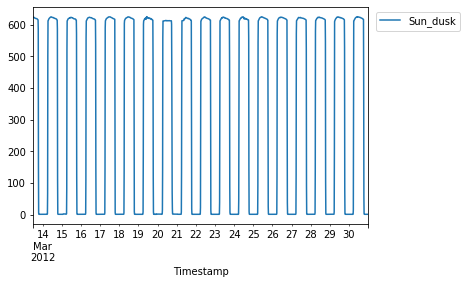

In [35]:
plot_cols = ['Sun_dusk']

data.loc[:'2012-3-30 23:59:59'].plot.line(y=plot_cols)
plt.legend(bbox_to_anchor=(1.01,1), )
# plt.axhline(1,linestyle='dashed')
plt.show()

In [36]:
import statsmodels.api as sm 

/home/alexandre/anaconda2/envs/data_science/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:666: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


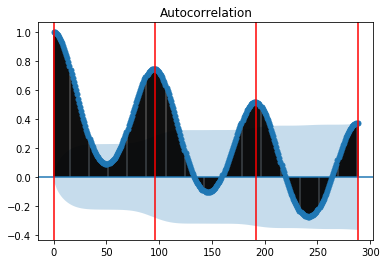

In [37]:
x = data.loc[:'2012-04-10', 'Temperature_dining_room']
acf_temp_dine = sm.tsa.stattools.acf(x, nlags=4*24*3)
sm.graphics.tsa.plot_acf(x, lags=4*24*3)
for n in range(4):
    plt.axvline(4*24*n,color='red')

In [38]:
#
# The ACF plots seems to indicate daily seasonality, as expected.
# (Since 1 lag unit corresponds to 15 minutes, 96 lag units corresponds to 1 day)
# The red lines are lags of 0 days, 1 day, 2 days and 3 days.
# 

acf_temp_dine[80:100]

array([0.55986584, 0.58119134, 0.60177418, 0.62148433, 0.6401897 ,
       0.6577676 , 0.67410144, 0.68907915, 0.7025959 , 0.71454564,
       0.72483519, 0.73338384, 0.74012209, 0.74499123, 0.74794294,
       0.7489404 , 0.74796137, 0.74500472, 0.74008626, 0.73322395])

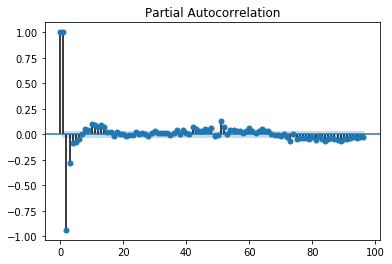

In [41]:
x = data.loc[:'2012-04-10', 'Temperature_dining_room']
acf_temp_dine = sm.tsa.stattools.pacf(x, nlags=4*24)
sm.graphics.tsa.plot_pacf(x, lags=4*24)
plt.show()

# Models

For all models,
- __Target__: Indoor Dining Room Temperature, Indoor Room Temperature, 1 step ahead
- __Features Past Window size__: 96 (1 day)
- __Features__: Indoor Temp in Dining room and room, Outdoor Temp, CO2 in dining room and room, Humidity in dining room and room, lighting in dining room and room,  wind, sun light in all facades, sun irradiance, day of the week and hour of the day.
- Transform __temperature__ from Celsius to __Kelvin__. This way, the zero point is explicit. Although celsius let negative values, they are bounded below by -273.15ºC.
- __Humidity__ we will just __divide by 100__. (percent to decimal)
- __One hot encoding week day__
- __Fourier__ terms for the hour of the day (cosine, sine pair).

## Pre-processing

In [42]:
def celsius_to_kelvin(x):
    return x + 273.15

def percent_to_decimal(x):
    return x/100

def cosine_term(x, period):
    return np.cos(2*np.pi*x/period)

def sine_term(x, period):
    return np.sin(2*np.pi*x/period)

In [43]:
data.columns

Index(['Date', 'Time', 'Temperature_dining_room', 'Temperature_room',
       'Weather_temperature', 'CO2_dining_room', 'CO2_room',
       'Humidity_dining_room', 'Humidity_room', 'Lighting_dining_room',
       'Lighting_room', 'Rain', 'Sun_dusk', 'Wind', 'Sun_light_west',
       'Sun_light_east', 'Sun_light_south', 'Sun_irradiance',
       'Enthalpic_motor_1', 'Enthalpic_motor_2', 'Enthalpic_motor_turbo',
       'Outdoor_temperature', 'Outdoor_relative_humidity', 'Day_of_week'],
      dtype='object')

In [44]:
data_proc = \
(
    data.assign(temp_dine=lambda row:celsius_to_kelvin(row['Temperature_dining_room']))
        .assign(temp_room=lambda row:celsius_to_kelvin(row['Temperature_room']))
        .assign(temp_out=lambda row:celsius_to_kelvin(row['Outdoor_temperature']))
        .assign(humid_dine=lambda row:percent_to_decimal(row['Humidity_dining_room']))
        .assign(humid_room=lambda row:percent_to_decimal(row['Humidity_room']))
        .assign(humid_out=lambda row:percent_to_decimal(row['Outdoor_relative_humidity']))
        .assign(day_hour=data.index.hour)
        .assign(cos_hour=lambda row:cosine_term(row['day_hour'], 24))
        .assign(sin_hour=lambda row:sine_term(row['day_hour'], 24))
)

In [45]:
data_proc = pd.get_dummies(data_proc, prefix=['day'], columns=['Day_of_week'])

In [58]:
data_proc.columns

Index(['Date', 'Time', 'Temperature_dining_room', 'Temperature_room',
       'Weather_temperature', 'CO2_dining_room', 'CO2_room',
       'Humidity_dining_room', 'Humidity_room', 'Lighting_dining_room',
       'Lighting_room', 'Rain', 'Sun_dusk', 'Wind', 'Sun_light_west',
       'Sun_light_east', 'Sun_light_south', 'Sun_irradiance',
       'Enthalpic_motor_1', 'Enthalpic_motor_2', 'Enthalpic_motor_turbo',
       'Outdoor_temperature', 'Outdoor_relative_humidity', 'temp_dine',
       'temp_room', 'temp_out', 'humid_dine', 'humid_room', 'humid_out',
       'day_hour', 'cos_hour', 'sin_hour', 'day_1.0', 'day_2.0', 'day_3.0',
       'day_4.0', 'day_5.0', 'day_6.0', 'day_7.0'],
      dtype='object')

In [59]:
cols = \
['temp_dine', 'temp_room', 'temp_out',
'CO2_dining_room', 'CO2_room',
'humid_dine', 'humid_room', 'humid_out',
'Lighting_dining_room', 'Lighting_room', 
'Rain', 'Sun_dusk', 'Wind', 
'Sun_light_west', 'Sun_light_east', 'Sun_light_south', 'Sun_irradiance',  
'cos_hour', 'sin_hour', 
'day_1.0', 'day_2.0', 'day_3.0', 'day_4.0', 'day_5.0', 'day_6.0', 'day_7.0']

In [83]:
model_data = data_proc.loc[:, cols].copy()
train_data = model_data.loc[:'2012-04-12 00:00:00'].copy()
test_data = model_data.loc['2012-04-12 00:00:00':].copy()

In [84]:
from sklearn.preprocessing import MinMaxScaler

In [85]:
scaler = MinMaxScaler()

In [86]:
scaler.fit(train_data)

MinMaxScaler()

In [87]:
df_final = model_data.copy()

In [88]:
df_final[cols] = scaler.transform(df_final)

In [89]:
df_final

,temp_dine,temp_room,temp_out,CO2_dining_room,CO2_room,humid_dine,humid_room,humid_out,Lighting_dining_room,Lighting_room,...,Sun_irradiance,cos_hour,sin_hour,day_1.0,day_2.0,day_3.0,day_4.0,day_5.0,day_6.0,day_7.0
Timestamp,,,,,,,,,,,,,,,,,,,,,
2012-03-13 11:45:00,0.481780,0.486840,0.429868,0.071787,0.078541,0.378720,0.388494,0.424315,0.709584,0.673925,...,0.739073,0.017037,0.62941,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-03-13 12:00:00,0.501219,0.507982,0.444357,0.080108,0.074836,0.379139,0.383352,0.415102,0.710347,0.674486,...,0.742162,0.000000,0.50000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-03-13 12:15:00,0.522646,0.530769,0.465561,0.078772,0.071434,0.374572,0.382788,0.408993,0.707172,0.674453,...,0.746213,0.000000,0.50000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-03-13 12:30:00,0.544171,0.553454,0.486707,0.076831,0.066943,0.374690,0.378909,0.402363,0.707946,0.672765,...,0.746005,0.000000,0.50000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-03-13 12:45:00,0.565273,0.574373,0.508428,0.074622,0.064647,0.374682,0.377997,0.377183,0.707590,0.670720,...,0.742815,0.000000,0.50000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-05-01 22:45:00,0.739216,0.740027,0.358559,0.024135,0.024919,0.481834,0.450988,0.665111,0.007844,0.021349,...,0.001238,0.933013,0.25000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-05-01 23:00:00,0.730568,0.732139,0.355175,0.024186,0.022330,0.484355,0.457130,0.657962,0.008657,0.023495,...,0.001238,0.982963,0.37059,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-05-01 23:15:00,0.722674,0.725029,0.353081,0.021250,0.021088,0.476638,0.457130,0.641756,0.009471,0.020277,...,0.001238,0.982963,0.37059,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [117]:
train_idx = pd.date_range(start='2012-03-13 11:45:00', end='2012-04-11 06:30:00', freq='15min')
test_idx = pd.date_range(start='2012-04-18 00:00:00', end='2012-05-01 23:45:00', freq='15min')

In [138]:
train = df_final.loc[train_idx]
test = df_final.loc[test_idx]

## Model 01: Naive forecasts

### Full naive

In [140]:
dine_temp_train = train.loc[:, 'temp_dine']
room_temp_train = train.loc[:, 'temp_room']

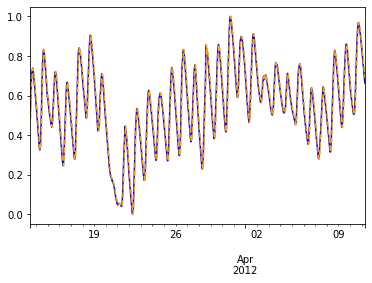

In [154]:
dine_temp_train.plot.line(color='blue')
dine_temp_train.shift(4).plot.line(color='orange',linestyle='dashed')
plt.show()

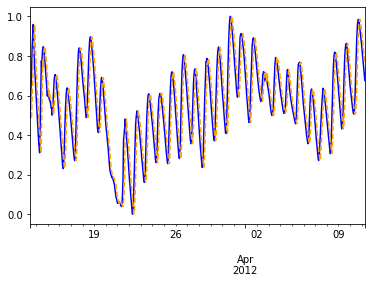

In [161]:
room_temp_train.plot.line(color='blue')
room_temp_train.shift(12).plot.line(color='orange', linestyle='dashed')
plt.show()

In [148]:
from sklearn.metrics import mean_absolute_percentage_error

In [149]:
dine_temp_test = test.loc[:, 'temp_dine']
room_temp_test = test.loc[:, 'temp_room']

In [160]:
mean_absolute_percentage_error(dine_temp_test[12:], dine_temp_test.shift(12)[12:])

0.11667400557994258

In [151]:
mean_absolute_percentage_error(room_temp_test[1:], room_temp_test.shift(1)[1:])

0.010157775995687233

## Model 02: Naive forecasts 2

## Model 03: ETS

## Model 04: ARIMA

## Model 05: SARIMAX

## Model 06: Hidden Markov Model

## Model 07: LSTM

## Model 08: LSTNet